In [ ]:
import torchvision
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
import time
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(linewidth=120)

# CNN Implementation using PyTortch (25 points)

In [ ]:
train_set = torchvision.datasets.FashionMNIST(root="./", download=True, 
                                              train=True,
                                              transform=transforms.Compose([transforms.ToTensor()]))

test_set = torchvision.datasets.FashionMNIST(root="./", download=True, 
                                              train=False,
                                              transform=transforms.Compose([transforms.ToTensor()]))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
data_loader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True)
sample = next(iter(data_loader))

imgs, lbls = sample

image tensor: torch.Size([10, 1, 28, 28])
class labels: tensor([8, 5, 5, 9, 2, 1, 2, 2, 0, 4])


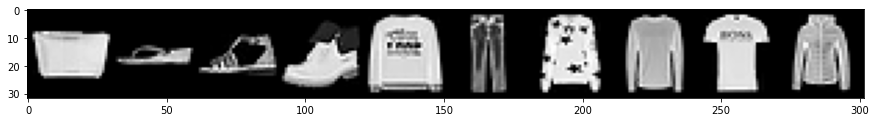

In [ ]:
# create a grid 
plt.figure(figsize=(15,10))
grid = torchvision.utils.make_grid(nrow=20, tensor=imgs)
print(f"image tensor: {imgs.shape}")
print(f"class labels: {lbls}")
plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray');

In [ ]:
# define some helper functions
def get_item(preds, labels):
    """function that returns the accuracy of our architecture"""
    return preds.argmax(dim=1).eq(labels).sum().item()

@torch.no_grad() 
def get_all_preds(network, dataloader):
    """function to return the number of correct predictions across data set"""
    all_preds = torch.tensor([])
    model = network
    for batch in dataloader:
        images, labels = batch
        preds = model(images) 
        all_preds = torch.cat((all_preds, preds), dim=0) 
        
    return all_preds


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
  
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()



In [ ]:
# define network

class Network(nn.Module): # extend nn.Module class of nn
    def __init__(self):
        super().__init__() # super class constructor
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5))
        self.batchN1 = nn.BatchNorm2d(num_features=6)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(5,5))
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.batchN2 = nn.BatchNorm1d(num_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
        
        
    def forward(self, t): 
        
        # hidden conv layer 
        t = self.conv1(t)
        t = F.max_pool2d(input=t, kernel_size=2, stride=2)
        t = F.relu(t)
        t = self.batchN1(t)
        
        # hidden conv layer
        t = self.conv2(t)
        t = F.max_pool2d(input=t, kernel_size=2, stride=2)
        t = F.relu(t)
        
        # flatten
        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t)
        t = self.batchN2(t)
        t = self.fc2(t)
        t = F.relu(t)
        
        # output
        t = self.out(t)
        
        return t        
cnn_model = Network() # init model
print(cnn_model) # print model structure


Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (batchN1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (batchN2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)


In [ ]:

mean = 0.2859;  std = 0.3530 # calculated using standization from the MNIST itself which we skip in this blog
train_set = torchvision.datasets.FashionMNIST(root="./", download=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean, std)]))
data_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True, num_workers=1)


In [ ]:
optimizer = optim.Adam(lr=0.01, params=cnn_model.parameters())
# def train loop

for epoch in range(10):
    start_time = time.time()
    total_correct = 0
    total_loss = 0
    n_samples = 0
    for batch in data_loader:
        imgs, lbls = batch
        preds = cnn_model(imgs) # get preds
        loss = F.cross_entropy(preds, lbls) # compute loss
        optimizer.zero_grad() # zero grads
        loss.backward() # calculates gradients 
        optimizer.step() # update the weights
        
        #total_loss += loss.item()
       # n_samples += lbls.size(0)
        total_correct += get_item(preds, lbls)
        accuracy = 100.0*(total_correct/len(train_set))
        #accuracy1 = 100.0*(total_correct/n_samples)
    end_time = time.time() - start_time    
    print("Epoch no.",epoch+1 ,"|accuracy: ", round(accuracy, 3),"%", "|Loss: ", round(loss.item(), 3), "| epoch_duration: ", round(end_time,2),"sec")


Epoch no. 1 |accuracy:  88.173 % |Loss:  0.51 | epoch_duration:  35.33 sec
Epoch no. 2 |accuracy:  87.128 % |Loss:  0.211 | epoch_duration:  36.38 sec
Epoch no. 3 |accuracy:  88.162 % |Loss:  0.183 | epoch_duration:  34.28 sec
Epoch no. 4 |accuracy:  87.635 % |Loss:  0.316 | epoch_duration:  34.82 sec
Epoch no. 5 |accuracy:  87.268 % |Loss:  0.204 | epoch_duration:  34.54 sec
Epoch no. 6 |accuracy:  87.922 % |Loss:  0.507 | epoch_duration:  34.42 sec
Epoch no. 7 |accuracy:  88.932 % |Loss:  0.465 | epoch_duration:  35.11 sec
Epoch no. 8 |accuracy:  88.808 % |Loss:  0.345 | epoch_duration:  35.22 sec
Epoch no. 9 |accuracy:  87.14 % |Loss:  0.046 | epoch_duration:  36.31 sec
Epoch no. 10 |accuracy:  88.253 % |Loss:  0.254 | epoch_duration:  36.24 sec


In [ ]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10, shuffle=True)
sample1 = next(iter(test_loader))

images, labels = sample1

In [ ]:
from torch.autograd import Variable
cnn_model.eval()

with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = Variable(images.float())
      outputs = cnn_model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum()
  print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * (correct / total)))

Test Accuracy of the model on the 10000 test images: 87.2900 %
